# Plot 4 — Message Passing: Before vs After a GNN Layer

In this exercise you will:
1) Learn the core idea of **message passing** in Graph Neural Networks (GNNs): **neighbor aggregation**.  
2) Visualize node representations **before vs after** a message-passing layer.  
3) Modify one or more choices (graph, features, aggregation rule, number of steps, etc.) to generate **your own** plot for submission.

**Minimum requirement for your final plot**
- Two subplots labeled **Before** and **After**
- **Same node coloring in both plots**
- Export as **PNG or PDF**, *or* show the notebook output cell


## 0. Setup

Run the cell below to import packages. If `networkx` is not installed in your environment, install it with:
```bash
pip install networkx
```


In [1]:
!pip install networkx numpy matplotlib


In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# For reproducibility
rng = np.random.default_rng(0)

# Matplotlib defaults (no special styling)
plt.rcParams["figure.dpi"] = 130


## 1. Graph + Node Features (Tutorial)

A GNN takes:
- a **graph structure** (nodes + edges), and
- **node features** (a vector for each node),

and produces new node representations by repeatedly:
- sending messages between neighbors, and
- aggregating them.

### Task 1A (warm-up): Build a graph
We will use a small toy graph so you can see what's happening.

**Try it:** Change `n_nodes` or the graph generator and rerun to see different structures.


In [8]:
# --- Choose a toy graph ---
n_nodes = 20

# Option A: Barabási–Albert (hub structure)
G = nx.barabasi_albert_graph(n=n_nodes, m=2, seed=0)

# Option B: Erdos–Renyi (random edges) — uncomment to try
# G = nx.erdos_renyi_graph(n=n_nodes, p=0.15, seed=0)

# Option C: 2D grid graph — uncomment to try (note: node labels change)
# side = 5
# G = nx.grid_2d_graph(side, side)
# G = nx.convert_node_labels_to_integers(G)

# Layout (fixed so "Before" and "After" are comparable)
pos = nx.spring_layout(G, seed=0)

# --- Create node features ---
# We'll start with 1D features to keep plotting simple.
# Think: each node has a scalar "state" that will be updated by message passing.
x0 = rng.normal(loc=0.0, scale=1.0, size=(G.number_of_nodes(), 1))

print("Graph:", G)
print("x0 shape:", x0.shape)
print("First 5 node features:", x0[:5].ravel())


Graph: Graph with 20 nodes and 36 edges
x0 shape: (20, 1)
First 5 node features: [ 0.11566183 -1.07054441 -1.0026843  -0.64026241  0.73230171]


## 2. Message Passing Layer (Tutorial)

A simple message passing update for node *i* is:

$$
x_i' = \sigma\Big( w_{\text{self}} x_i \; + \; w_{\text{nbr}} \cdot \text{AGG}(\{x_j: j \in N(i)\}) \Big)
$$

Where:
- $N(i)$ are neighbors of node *i*
- **AGG** is an aggregation function like **mean/sum/max**
- $w_{self}, w_{nbr}$ are weights (we’ll use scalars here)
- $\sigma$ is a nonlinearity (we’ll use `tanh`)

### Task 2A: Implement neighbor aggregation
Complete the `neighbor_aggregate` function.
- It should return an array of shape `(num_nodes, feature_dim)`
- Use **mean** over neighbors by default
- If a node has no neighbors, return zeros for that node

### Task 2B: Implement one message passing step
Complete `message_passing_step` using the formula above.


In [9]:
def neighbor_aggregate(G, X, agg="mean"):
    '''
    Aggregate neighbor features for each node.

    Parameters
    ----------
    G : networkx.Graph
        Input graph.
    X : np.ndarray, shape (N, D)
        Node features.
    agg : {"mean", "sum", "max"}
        Aggregation function.

    Returns
    -------
    A : np.ndarray, shape (N, D)
        Aggregated neighbor features for each node.
    '''
    N, D = X.shape
    A = np.zeros((N, D), dtype=float)

    # Task 2A: Aggregate neighbor features for each node in the graph.
    # Iterate over every node and collect its neighbors' features, then reduce them.
    for i in range(N):
        # Get all neighbor indices of node i. G.neighbors(i) returns an iterator,
        # so we convert to list for indexing into X.
        nbrs = list(G.neighbors(i))
        # Isolated nodes have no neighbors: leave A[i] as zeros (already initialized).
        if len(nbrs) == 0:
            continue
        # Extract the feature vectors of all neighbors. X[nbrs, :] has shape (deg(i), D)
        # where deg(i) is the number of neighbors of node i.
        nbr_feats = X[nbrs, :]  # shape (deg(i), D)

        # Reduce neighbor features along axis=0 (across neighbors) using the requested agg.
        # mean: average of neighbors (common in GNNs for degree normalization)
        # sum: sum of neighbors (can emphasize hubs with many connections)
        # max: element-wise max (permutation-invariant, used in GraphSAGE)
        if agg == "mean":
            A[i, :] = nbr_feats.mean(axis=0)
        elif agg == "sum":
            A[i, :] = nbr_feats.sum(axis=0)
        elif agg == "max":
            A[i, :] = nbr_feats.max(axis=0)
        else:
            raise ValueError(f"Unknown agg='{agg}'. Use 'mean', 'sum', or 'max'.")
    return A


def message_passing_step(G, X, w_self=1.0, w_nbr=1.0, agg="mean", nonlinearity="tanh"):
    '''
    One message passing step.

    X' = sigma( w_self * X + w_nbr * AGG_neighbors(X) )
    '''
    # Task 2B: Combine self-features and aggregated neighbor features, then apply nonlinearity.
    # Step 1: Compute AGG(X_j for j in N(i)) — aggregated neighbor features per node.
    nbr = neighbor_aggregate(G, X, agg=agg)
    # Step 2: Linear combination. Z = w_self * X + w_nbr * nbr.
    # This blends each node's own representation with information from its neighbors.
    Z = w_self * X + w_nbr * nbr

    # Step 3: Apply nonlinearity to bound/activate the updated representation.
    # tanh maps to (-1, 1); ReLU zeros negatives; "none" keeps Z unchanged.
    if nonlinearity == "tanh":
        return np.tanh(Z)
    elif nonlinearity == "relu":
        return np.maximum(0.0, Z)
    elif nonlinearity == "none":
        return Z
    else:
        raise ValueError("nonlinearity must be one of {'tanh','relu','none'}")


# Quick sanity check
X1 = message_passing_step(G, x0, w_self=1.0, w_nbr=1.0, agg="mean", nonlinearity="tanh")
print("X1 shape:", X1.shape)
print("First 5 updated features:", X1[:5].ravel())


X1 shape: (20, 1)
First 5 updated features: [-0.43130094 -0.74198553 -0.85243249 -0.71491958  0.53980376]


## 3. Plot: Before vs After Message Passing (Required Plot Format)

We will draw the same graph twice:
- **Before**: node color encodes the initial feature \(x_0\)
- **After**: node color encodes the updated feature \(x_1\)

### Important requirement
To make comparisons meaningful:
- Use the **same layout** (`pos`) in both subplots
- Keep **the same color mapping rule** (we will use a shared color range)


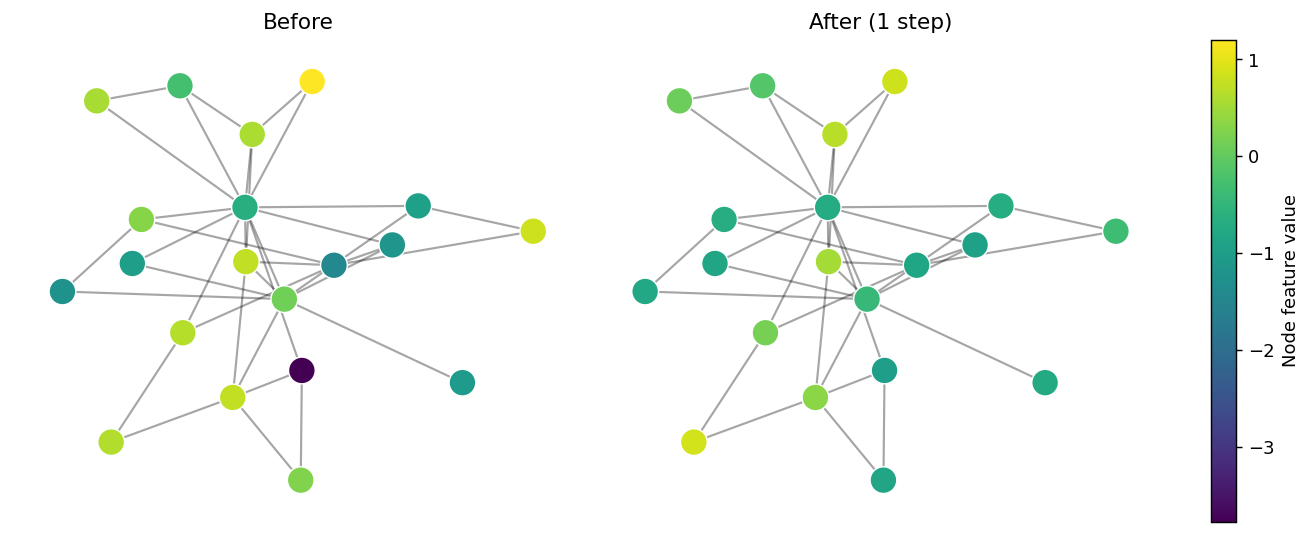

In [10]:
def plot_before_after(G, pos, x_before, x_after, title_before="Before", title_after="After"):
    '''
    Two-panel plot with consistent coloring across panels.
    We enforce the same vmin/vmax for both plots.
    '''
    # Expect 1D features for coloring
    v_before = x_before.ravel()
    v_after = x_after.ravel()

    # Shared color scale across panels (required)
    vmin = float(min(v_before.min(), v_after.min()))
    vmax = float(max(v_before.max(), v_after.max()))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

    for ax, vals, ttl in zip(axes, [v_before, v_after], [title_before, title_after]):
        ax.set_title(ttl)
        ax.set_axis_off()
        nodes = nx.draw_networkx_nodes(
            G, pos, ax=ax,
            node_color=vals,
            vmin=vmin, vmax=vmax,
            cmap="viridis",
            node_size=220,
            linewidths=0.8,
            edgecolors="white",
        )
        nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.35, width=1.2)

    # One shared colorbar (also makes the "same coloring" constraint explicit)
    cbar = fig.colorbar(nodes, ax=axes, fraction=0.046, pad=0.04)
    cbar.set_label("Node feature value")

    return fig


# --- Generate "After" features with one message passing layer ---
x1 = message_passing_step(G, x0, w_self=1.0, w_nbr=1.0, agg="mean", nonlinearity="tanh")

fig = plot_before_after(G, pos, x0, x1, title_before="Before", title_after="After (1 step)")
plt.show()


## 4. Interpretation (Mini-check)

Answer in 1–3 sentences (no need to submit):
- Where do you see the largest changes?
- How does the graph structure (e.g., hubs vs regular nodes) affect the update?


## 5. Your Turn: Customize for Submission

In this section, you will change at least one of the following, run 5 message passing steps (n_steps), and then regenerate the plot:
- Graph type (BA vs ER vs grid, etc.)
- Aggregation rule (`mean`, `sum`, `max`)
- Weights (`w_self`, `w_nbr`) or nonlinearity (`tanh`, `relu`, `none`)
- Initial node features (`x0` distribution, structured features, two clusters, etc.)

### Task 5A (required): Make your own Before/After plot
- Keep **two subplots** labeled Before and After
- Keep **the same coloring scale** for both subplots (already handled by `plot_before_after`)
- Export the figure or show the cell output

Tip: If you do multiple steps, compare `x0` vs `xT`.


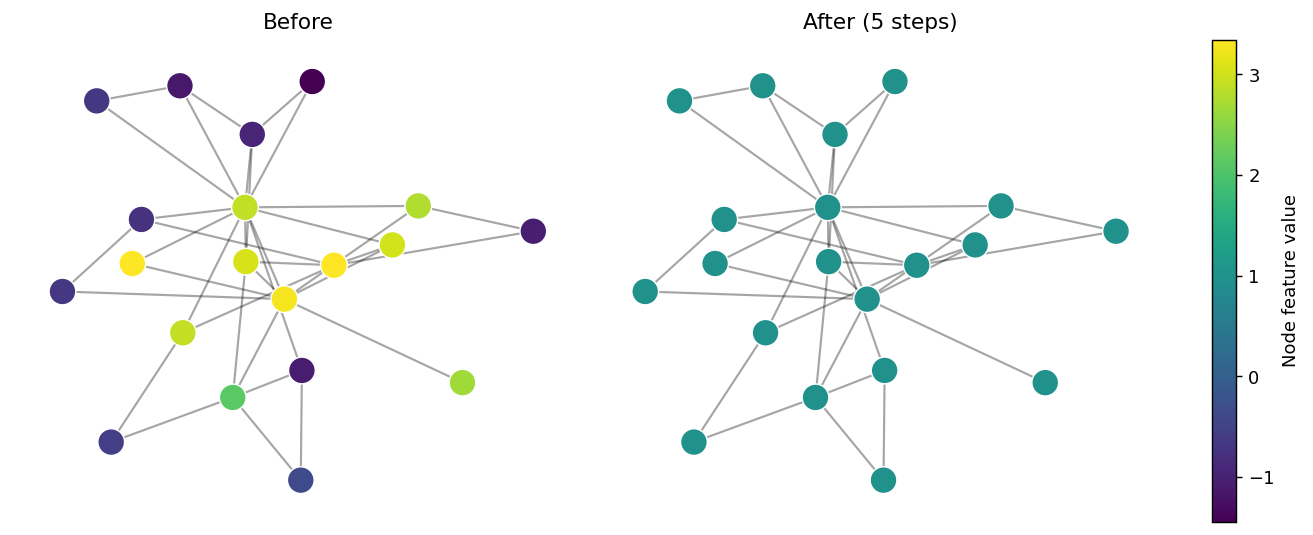

In [ ]:
# ============== EDIT THIS CELL FOR YOUR SUBMISSION ==============

# 1) Choose how many message passing steps
n_steps = 5

# 2) Choose message passing hyperparameters
agg = "mean"          # "mean", "sum", "max"
w_self = 0.8
w_nbr = 1.2
nonlinearity = "tanh" # "tanh", "relu", "none"

# 3) (Optional) Modify initial features
# Example: two clusters of initial values
x0 = rng.normal(loc=-1.0, scale=0.4, size=(G.number_of_nodes(), 1))
x0[: G.number_of_nodes()//2] += 2.0

# 4) Run message passing for n_steps (write your own)
x_current = x0.copy()
for _ in range(n_steps):
    x_current = message_passing_step(G, x_current, w_self=w_self, w_nbr=w_nbr, agg=agg, nonlinearity=nonlinearity)
x_after = x_current

# 5) Plot required before and after figure (write your own)
fig = plot_before_after(G, pos, x0, x_after, title_before="Before", title_after=f"After ({n_steps} steps)")
plt.show()


## Submission

Upload **one** of the following:
- The figure (**PNG or PDF**), **OR**
- The notebook cell output showing the figure

Also include a **short caption (1–2 sentences)**.

### Required Submission Template (copy-paste)

**Title:**  
What question does this plot answer?

**Description (1–2 sentences):**  
What data / model / comparison is shown?


### Quick checklist (before you submit)
- [ ] Two subplots labeled **Before** and **After**
- [ ] **Same node coloring** across panels (shared colorbar / shared vmin-vmax)
- [ ] Caption (1–2 sentences) included with the template